# Passo 1: Coleta de Dados

## Escolha da Empresa
Para este projeto, escolhemos a empresa **Telefônica Brasil (VIVT3.SA)** para prever o valor de fechamento das suas ações.

## Fonte de Dados
Utilizaremos a biblioteca `yfinance` para coletar os dados históricos das ações da Vivo. A `yfinance` é uma biblioteca Python que permite acessar dados financeiros do Yahoo Finance.

## Período de Dados
Definimos o período de tempo para os dados históricos como os últimos 5 anos, de 1º de janeiro de 2020 a 31º de Dezembro de 2024.


In [15]:
import yfinance
import pandas as pd


symbol = 'VIVT3.SA'
data = yfinance.download(symbol, start='2020-01-01', end='2024-12-31')
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA
Date,,,,,
2020-01-02,35.208382,35.485726,34.894542,35.456534,38100
2020-01-03,35.617104,35.755779,34.580706,35.135397,49900
2020-01-06,35.274071,35.733880,35.149993,35.500325,43700
2020-01-07,36.055012,36.055012,35.135388,35.237568,46400
2020-01-08,36.419952,36.434547,35.770376,36.055023,47800


In [16]:
data.shape

(1244, 5)

In [17]:
data.columns

MultiIndex([( 'Close', 'VIVT3.SA'),
            (  'High', 'VIVT3.SA'),
            (   'Low', 'VIVT3.SA'),
            (  'Open', 'VIVT3.SA'),
            ('Volume', 'VIVT3.SA')],
           names=['Price', 'Ticker'])

# Passo 2: Pré-processamento de Dados


In [18]:
#Tratamento de Valores Ausentes
data.isnull().sum()
# data = data.dropna()

Price   Ticker  
Close   VIVT3.SA    0
High    VIVT3.SA    0
Low     VIVT3.SA    0
Open    VIVT3.SA    0
Volume  VIVT3.SA    0
dtype: int64

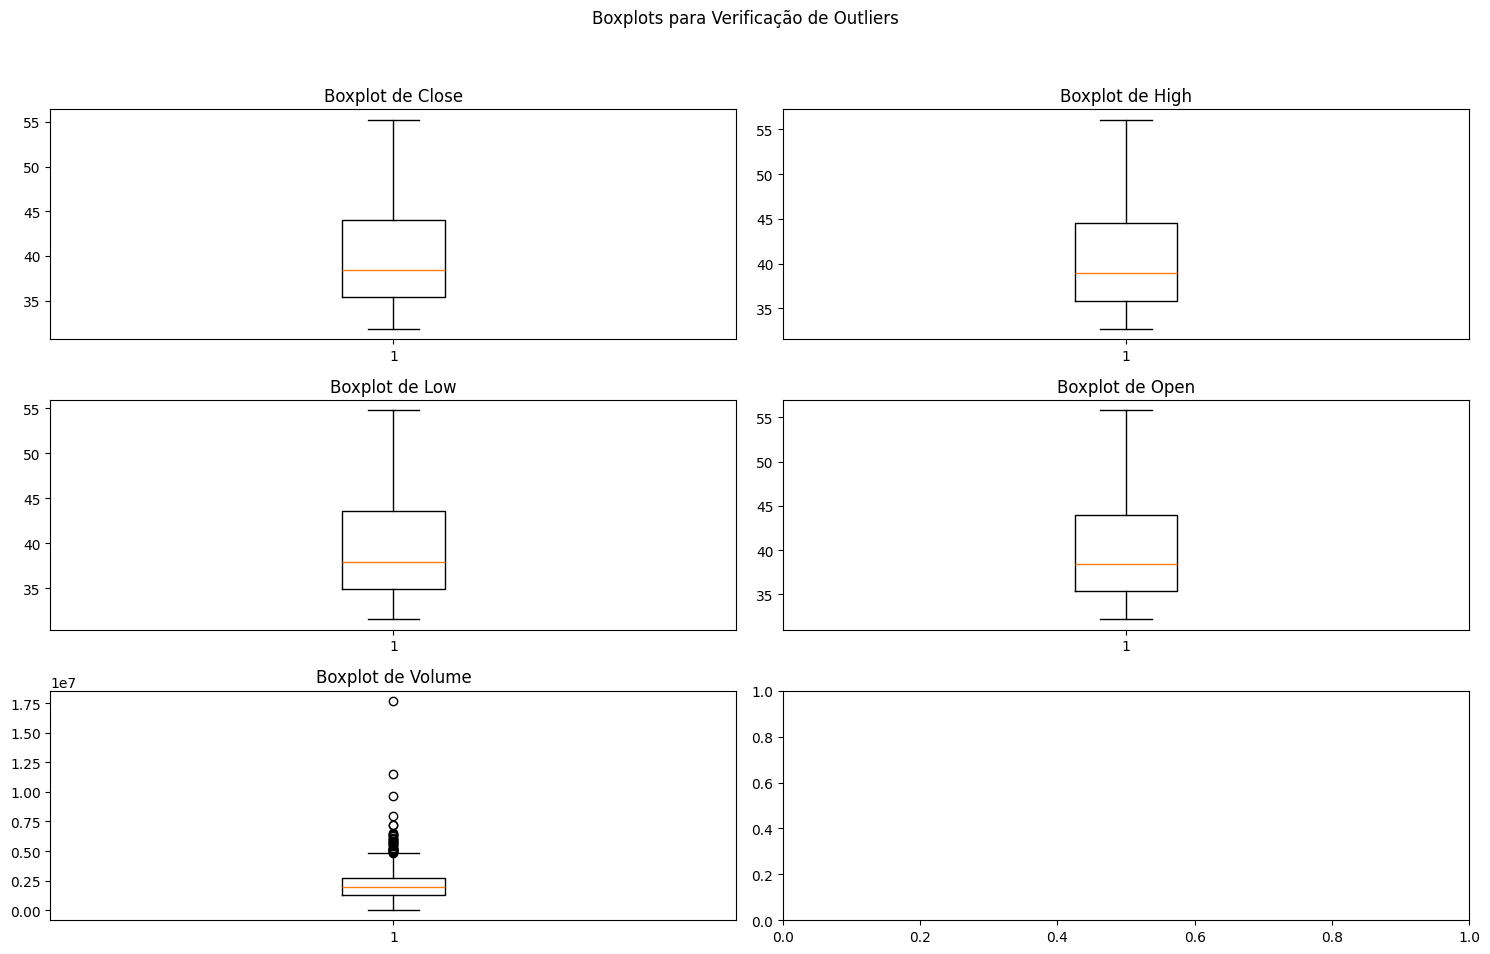

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Boxplots para Verificação de Outliers')

#columns = [('Adj Close', 'VIVT3.SA'),
columns = [('Close', 'VIVT3.SA'), ('High', 'VIVT3.SA'),
           ('Low', 'VIVT3.SA'), ('Open', 'VIVT3.SA'), ('Volume', 'VIVT3.SA')]

for ax, col in zip(axes.flatten(), columns):
    ax.boxplot(data[col])
    ax.set_title(f'Boxplot de {col[0]}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA
count,1244.000000,1244.000000,1244.000000,1244.000000,1.244000e+03
mean,40.158647,40.630942,39.701765,40.158610,2.024460e+06
std,5.771502,5.795057,5.756529,5.754472,1.394775e+06
min,31.877623,32.758313,31.584822,32.209664,3.370000e+04
25%,35.391286,35.807524,34.960511,35.381585,1.322700e+06
50%,38.404091,38.947875,37.933013,38.439113,1.985950e+06
75%,44.049857,44.546481,43.597026,43.968727,2.732900e+06
max,55.237522,56.054907,54.764819,55.789012,1.766530e+07


In [21]:
#Verificando col Volume
df = pd.DataFrame(data)

# Visualizar a coluna Volume
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[('Volume', 'VIVT3.SA')], marker='o', linestyle='-', color='b')
plt.title('Volume de Negociação ao Longo do Tempo')
plt.xlabel('Índice')
plt.ylabel('Volume')
plt.show()

KeyboardInterrupt: 

In [ ]:
#Normalização e Padronização
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler()

# data_normalized = scaler.fit_transform(data)
# data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

# Normalização (evitando data leakage)
train_size = int(len(data) * 0.8)
scaler = MinMaxScaler()
scaler.fit(data[:train_size])  # Ajusta apenas nos dados de treino
data_normalized = scaler.transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

data_normalized.describe()

Price,Close,High,Low,Open,Volume
Ticker,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,0.436125,0.426192,0.431153,0.420393,0.112909
std,0.303960,0.313721,0.305773,0.304335,0.079107
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185049,0.165072,0.179309,0.167752,0.073107
50%,0.343720,0.335077,0.337201,0.329454,0.110724
75%,0.641058,0.638163,0.638060,0.621897,0.153089
max,1.230263,1.261182,1.231266,1.247032,1.000000


In [9]:
#Verificação para codificar dados categóricos
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1244 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, VIVT3.SA)   1244 non-null   float64
 1   (High, VIVT3.SA)    1244 non-null   float64
 2   (Low, VIVT3.SA)     1244 non-null   float64
 3   (Open, VIVT3.SA)    1244 non-null   float64
 4   (Volume, VIVT3.SA)  1244 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.3 KB


In [10]:
#Verificando se é necessário tratamento de inconsistências
data.head()

Price,Close,High,Low,Open,Volume
Ticker,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA,VIVT3.SA
Date,,,,,
2020-01-02,35.208382,35.485726,34.894542,35.456534,38100
2020-01-03,35.617104,35.755779,34.580706,35.135397,49900
2020-01-06,35.274071,35.733880,35.149993,35.500325,43700
2020-01-07,36.055012,36.055012,35.135388,35.237568,46400
2020-01-08,36.419952,36.434547,35.770376,36.055023,47800


# Desenvolvimento do Modelo LSTM


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np

2025-02-13 20:48:58.608916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 20:48:58.610397: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 20:48:58.613927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 20:48:58.624283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739490538.637556    8462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739490538.64

In [12]:
# Criando sequências de dados
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Definição do tamanho da sequência
seq_length = 60
X, y = create_sequences(data_normalized.values, seq_length)

X.shape, y.shape

((1183, 60, 5), (1183,))

In [ ]:
# Divisão dos Dados em Treino e Teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:train_size + len(X) - train_size]
y_train, y_test = y[:train_size], y[train_size:train_size + len(X) - train_size]
X_train.shape, X_test.shape

((946, 60, 5), (237, 60, 5))

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

seed_value = 42

# Definir semente para as bibliotecas numpy, random e tensorflow
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Construção do modelo LSTM
def build_model(input_shape=None):
    model = Sequential([
        LSTM(300, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),  # Regularização L2
        Dropout(0.5),
        BatchNormalization(),
        LSTM(200, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        LSTM(100, return_sequences=False, kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    # Compilação do modelo
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Defina o input_shape com base no seu conjunto de dados
input_shape = (X_train.shape[1], X_train.shape[2])

# Criar o modelo
model = build_model(input_shape)

# Tente carregar os pesos salvos (caso você tenha pesos salvos previamente)
try:
    model.load_weights('modelo_pesos.weights.h5')
    print("Pesos carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar pesos: {e}")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Salvar os pesos após o treinamento
model.save_weights('modelo_pesos.weights.h5')

# Salvar o modelo completo, incluindo a arquitetura e os pesos
model.save('modelo_completo.h5')

# Verificar a arquitetura do modelo
model.summary()


2025-02-13 20:48:59.814622: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/ayres/Documents/pos-tech-fiap-tech-challenge-4/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Erro ao carregar pesos: [Errno 2] Unable to synchronously open file (unable to open file: name = 'modelo_pesos.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - loss: 0.8723 - val_loss: 0.9153
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - loss: 0.7877 - val_loss: 0.9151
Epoch 3/200
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.7494

KeyboardInterrupt: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
MAE: 0.95, RMSE: 1.20, MAPE: 0.02, R2: 0.86


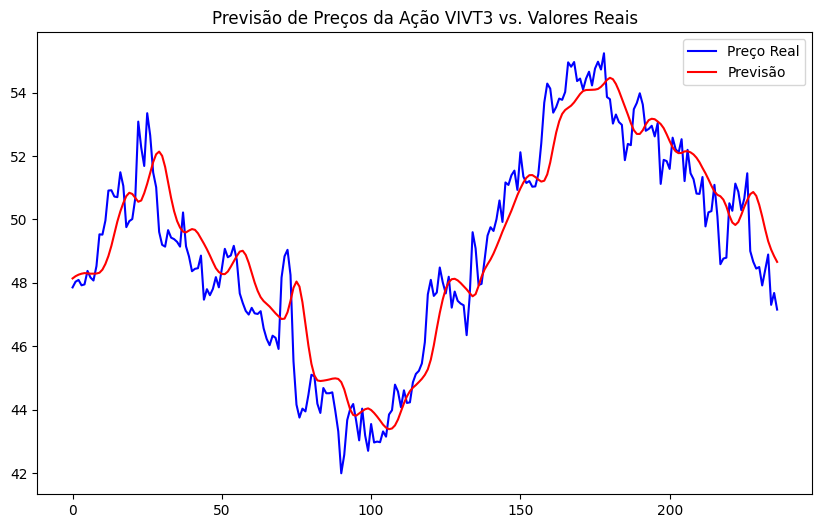

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Fazer previsões
y_pred = model.predict(X_test)

# Desnormalização
y_test_desnormalized = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data_normalized.shape[1] - 1))])
)[:, 0]

y_pred_desnormalized = scaler.inverse_transform(
    np.pad(y_pred.reshape(-1, 1), ((0, 0), (0, data_normalized.shape[1] - 1)), mode='constant')
)[:, 0]

# Avaliação do Modelo
mae = mean_absolute_error(y_test_desnormalized, y_pred_desnormalized)
rmse = np.sqrt(mean_squared_error(y_test_desnormalized, y_pred_desnormalized))
mape = mean_absolute_percentage_error(y_test_desnormalized, y_pred_desnormalized)
r2 = r2_score(y_test_desnormalized, y_pred_desnormalized)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}, y_pred: {y_pred_desnormalized}')

# Visualização das previsões
plt.figure(figsize=(10, 6))
plt.plot(y_test_desnormalized, label='Preço Real', color='blue')
plt.plot(y_pred_desnormalized, label='Previsão', color='red')
plt.legend()
plt.title('Previsão de Preços da Ação VIVT3 vs. Valores Reais')
plt.show()

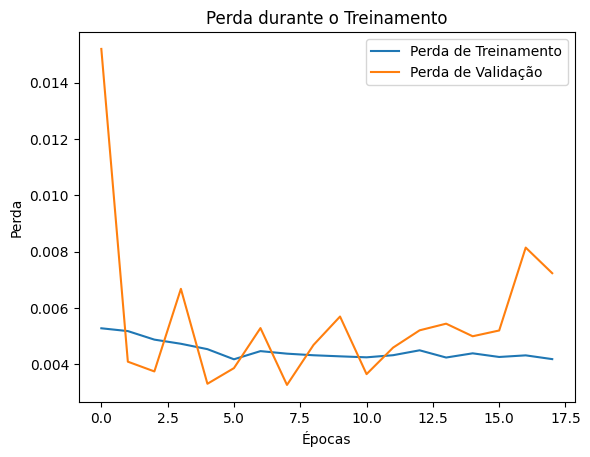

In [16]:
import matplotlib.pyplot as plt

# Plotando a perda de treinamento e validação
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [17]:
print(f'Forma de y_test: {y_test.shape}')
print(f'Forma de y_pred: {y_pred.shape}')

Forma de y_test: (237,)
Forma de y_pred: (237, 1)


In [18]:
import pickle as pkl

#salvar scaler para retreino com novos dados e teste
with open("scaler.pkl", "wb") as file:
    pkl.dump(scaler, file)

In [19]:
#carrega padronizador pra teste se esta funcionando
with open("scaler.pkl", "rb") as file:
    scaler = pkl.load(file)